In [49]:
using DifferentialEquations, Flux, Optim, DiffEqFlux, DiffEqSensitivity, OrdinaryDiffEq, ForwardDiff, Zygote, Plots


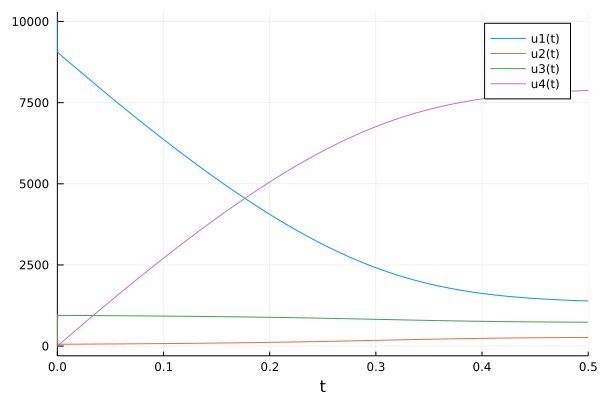

In [61]:
θ_true = [1.0, 500.0, 30.0, 0.01] # k_on, k_off, k_cat, k_uncat

u_0 = [10e3; 1e3; 0.0; 0.0] # S_0, E_0

function kinetics!(du, u, p, t)
    # u ordered S, E, ES, P
    du[1] = p[2] * u[3] - p[1] * u[2] * u[1]
    du[2] = p[2] * u[3] - p[1] * u[2] * u[1] + p[3] * u[3] - p[4] * u[2] * u[4]
    du[3] = p[1] * u[2] * u[1] - p[2] * u[3] - p[3] * u[3] + p[4] * u[2] * u[4]
    du[4] = p[3] * u[3] - p[4] * u[2] * u[4]
end

prob_true = ODEProblem(kinetics!, u_0, (0.0, 0.5), θ_true)
sol_true_pretty = solve(prob_true, Tsit5())
sol_true = solve(prob_true, Tsit5(), saveat=tsteps)

plot(sol_true_pretty)

In [51]:
tsteps = collect(0:0.05:0.5)

11-element Vector{Float64}:
 0.0
 0.05
 0.1
 0.15
 0.2
 0.25
 0.3
 0.35
 0.4
 0.45
 0.5

In [52]:
θ_0 = [1.0489415890738956, 9.301874926576737, 26.789395694394962, 0.8975846605968467]
prob = remake(prob_true, p=θ_0)

function loss(p)
  sol = solve(prob, Tsit5(), p=p, saveat=tsteps)
  loss = sum(abs2, sol_true[4, :] - sol[4, :])
  return loss, sol
end

loss (generic function with 1 method)

In [53]:
callback = function (p, l, pred)
  display(l)
  plt = plot(pred, ylim = (0, 6))
  display(plt)
  return false
end

#7 (generic function with 1 method)

In [63]:
result_ode = DiffEqFlux.sciml_train(loss, θ_0, ADAM(0.1), maxiters=400)
result_ode.minimizer


4-element Vector{Float64}:
  2.172431613071395
 10.333134408479873
 29.971454865081622
  0.5771483592923721

In [56]:
θ_true

4-element Vector{Float64}:
   1.0
 500.0
  30.0
   0.01

In [58]:
result_ode.minimum

50781.80582168694

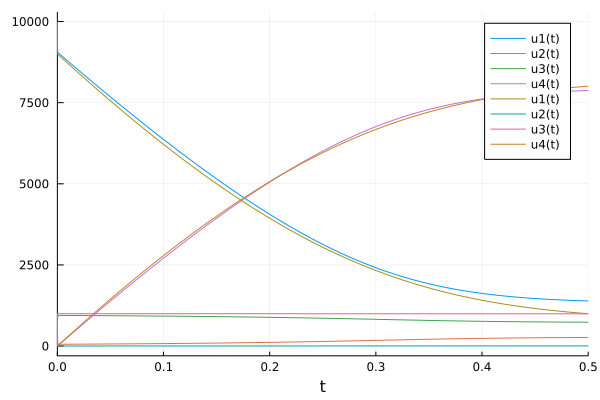

In [64]:
remade_solution = solve(remake(prob, p=result_ode.minimizer), Tsit5())
plot(sol_true_pretty)
plot!(remade_solution)